In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)

In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(context='talk', style='ticks',
        color_codes=True, rc={'legend.frameon': False})

%matplotlib inline

In [3]:
from rlmolecule.molecule.policy.model import policy_model
from rlmolecule.molecule.policy.preprocessor import load_preprocessor

prepreprocessor = load_preprocessor()
model = policy_model()

from rlmolecule.molecule.builder.builder import MoleculeBuilder
from rlmolecule.molecule.molecule_state import MoleculeState

import rdkit

INFO:rdkit:Enabling RDKit 2021.03.3 jupyter extensions


Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.


Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.


In [4]:
import itertools
import random

builder = MoleculeBuilder()
start = MoleculeState(rdkit.Chem.MolFromSmiles('C'), builder)

def iter_states(start):
    next_states = start.get_next_actions()
    random.shuffle(next_states)
    
    for next_state in next_states:
        if next_state.forced_terminal:
            yield next_state
        else:
            yield from iter_states(next_state)

In [5]:
random.seed(1)
mols = list(itertools.islice(iter_states(start), 2050))
random.shuffle(mols)

In [6]:
from timeit import timeit

In [7]:
def calc_batch_time(model, batch_size):
    
    batch_of_mols = mols[:batch_size]
    
    list_of_inputs = [prepreprocessor.construct_feature_matrices(
        mol.molecule, max_num_atoms=10, max_num_bonds=60) for mol in batch_of_mols]
    
    batched_inputs = {key: np.stack([elem[key] for elem in list_of_inputs])
                      for key in ['atom', 'bond', 'connectivity']}
    
    return timeit('model(batched_inputs)', globals=locals(), number=10) / 10

In [8]:
calc_batch_time(model, 32)  # initialize

0.05785873178392649

In [9]:
sizes = np.logspace(0, 12, base=2, dtype=int, num=12, endpoint=False)

In [11]:
times = [calc_batch_time(model, size) for size in sizes]

In [13]:
# pd.Series(times, index=sizes).to_csv('gpu.csv')

Text(0, 0.5, 'Time per sample (s)')

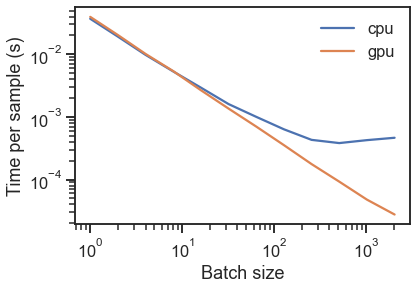

In [35]:
gpu = pd.read_csv('gpu.csv', index_col=0)
plt.loglog(sizes, times / sizes, '-', label='cpu')
plt.loglog(gpu.divide(gpu.index, axis=0), label='gpu')
plt.xlabel('Batch size')
plt.legend()
plt.ylabel('Time per sample (s)')

Text(0, 0.5, 'Time per batch (s)')

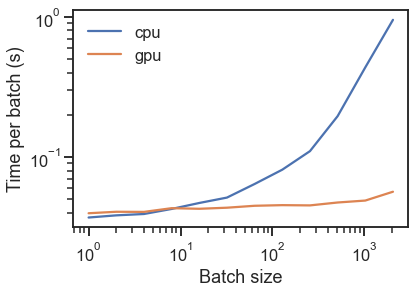

In [40]:
plt.loglog(sizes, times, '-', label='cpu')
plt.loglog(gpu, label='gpu')
plt.xlabel('Batch size')
plt.legend()
plt.ylabel('Time per batch (s)')

In [44]:
times[0]

0.03699773559346795